## Imports

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

import time
import os

from tempfile import TemporaryDirectory

from utils import natural_sort_key

In [2]:
# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
DATA_PATH = os.path.join(os.getcwd(), "data")

TASK1_PATH = os.path.join(DATA_PATH, "task1")
TRAIN_TASK1 = os.path.join(TASK1_PATH, "train_data", "annotations.csv")
TRAIN_TASK1_UNLABELED = os.path.join(TASK1_PATH, "train_data", "images", "unlabeled")

VAL_TASK1 = os.path.join(TASK1_PATH, "val_data")

TASK2_PATH = os.path.join(DATA_PATH, "task2")
TRAIN_TASK2 = os.path.join(TASK2_PATH, "train_data", "annotations.csv")
VAL_TASK2 = os.path.join(TASK2_PATH, "val_data")

## Load data

In [4]:
class LabeledData(Dataset):
    def __init__(self, annotation_file, transform=None) -> None:
        self._annotations = pd.read_csv(annotation_file)
        self.labels = self._annotations["label"]
        self.images_path = self._annotations["sample"]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(DATA_PATH, self.images_path[idx])
        image = Image.open(_path_to_image).convert("RGB")
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)


class UnlabeledData(Dataset):
    def __init__(self, image_dir, transform=None) -> None:
        self.image_dir = image_dir
        self.images_path = sorted(os.listdir(image_dir), key=natural_sort_key)
        self.labels = [None for x in range(len(self.images_path))]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(self.image_dir, self.images_path[idx])
        image = Image.open(_path_to_image).convert("RGB")

        try:
            label = self.labels[idx].item()

        except:
            label = 1000

        if self.transform:
            image = self.transform(image)

        return image, label, _path_to_image

    def __len__(self):
        return len(self.images_path)


class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None) -> None:
        self.images_path = dataframe["sample"]
        self.labels = dataframe["label"]

        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.images_path.loc[idx]).convert("RGB")
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)

In [5]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)

transform_augmented = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]
)

In [6]:
dataset = LabeledData(TRAIN_TASK1,transform=transform)

In [7]:
dataset_unlabeled = UnlabeledData(TRAIN_TASK1_UNLABELED,transform=transform)

In [8]:
def get_split_dataset(
    data,
    seed=42,
    test_size=0.2,
    batch_size = 64
):
    """Taken form https://stackoverflow.com/a/68338670"""
   
    # generate indices: instead of the actual data we pass in integers instead
    train_indices, test_indices, _, _ = train_test_split(
        range(len(data)),
        data.labels,
        stratify=data.labels,
        test_size=test_size,
        random_state=seed,
    )

    # generate subset based on indices
    train_split = Subset(data, train_indices)
    test_split = Subset(data, test_indices)

    # create batches
    train_batches = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    test_batches = DataLoader(test_split, batch_size=batch_size)

    return train_batches, test_batches

In [9]:
train_loader, valid_loader = get_split_dataset(dataset, batch_size=64)

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

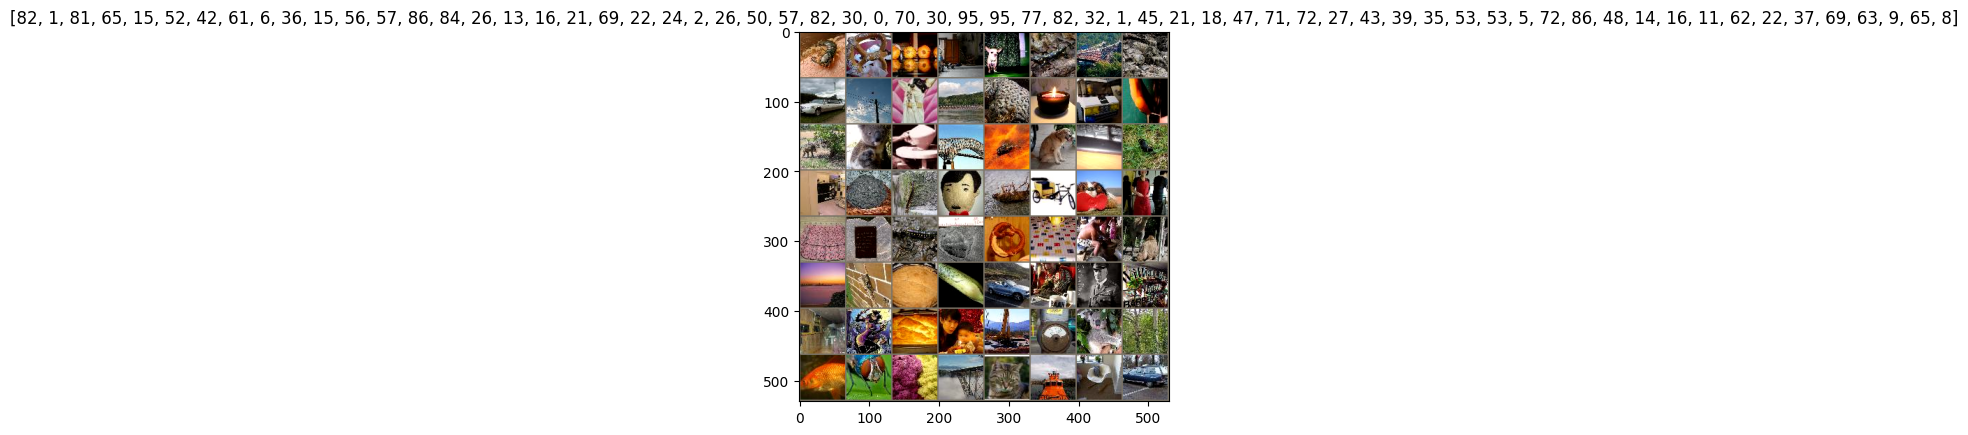

In [11]:
def test_loader(dataloader, is_labeled=True):
    # Get a batch of training data

    if is_labeled:
        inputs, classes = next(iter(dataloader))
    else:
        inputs, classes, _ = next(iter(dataloader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[x.item() for x in classes])


test_loader(train_loader)

## Base model resnet50

In [12]:
def train_model(
    model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=25
):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Training phase
            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = running_corrects.float() / len(train_loader)

            print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            print()

            model.eval()

            running_loss = 0.0
            running_corrects = 0
            # Validation phase
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(valid_loader)
            epoch_acc = running_corrects.float() / len(valid_loader)

            print(f"Valid\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    torch.save(model.state_dict(), best_model_params_path)

    return model


In [13]:
model_teacher = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_teacher.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_teacher.fc = nn.Linear(num_ftrs, 100)

model_teacher = model_teacher.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_teacher.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_teacher = train_model(
    model_teacher,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    valid_loader,
    num_epochs=8,
)

Epoch 0/7
----------
Train
	 Loss: 195.7683 Acc: 23.1661

Valid
	 Loss: 103.4830 Acc: 38.8784
Epoch 1/7
----------
Train
	 Loss: 85.8741 Acc: 42.2678

Valid
	 Loss: 77.6063 Acc: 43.6757
Epoch 2/7
----------
Train
	 Loss: 58.2281 Acc: 48.6305

Valid
	 Loss: 72.8011 Acc: 44.5000
Epoch 3/7
----------
Train
	 Loss: 41.6404 Acc: 52.9525

Valid
	 Loss: 71.3303 Acc: 45.0405
Epoch 4/7
----------
Train
	 Loss: 29.9752 Acc: 56.1864

Valid
	 Loss: 70.3756 Acc: 45.4865
Epoch 5/7
----------
Train
	 Loss: 22.3974 Acc: 58.2034

Valid
	 Loss: 71.4617 Acc: 45.5676
Epoch 6/7
----------
Train
	 Loss: 16.6387 Acc: 59.9898

Valid
	 Loss: 71.8877 Acc: 45.6622
Epoch 7/7
----------
Train
	 Loss: 12.1478 Acc: 61.3051

Valid
	 Loss: 72.4176 Acc: 45.5000
Training complete in 14m 15s
Best val Acc: 45.662163


In [14]:
import re
from tqdm import tqdm
from pathlib import Path


def predict(model, transform, img_path, base_dir=""):
    img = Image.open(os.path.join(base_dir, img_path)).convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return preds[0].item()


def write_submission(data: pd.DataFrame, task_name: str = None, filename: str = None):
    submission_dir = os.path.join(DATA_PATH, "submission", task_name)

    if task_name not in ["task1", "task2"]:
        raise TypeError(
            "Task name is mandatory and can have the value: Task1 or Task2."
        )

    if not Path(submission_dir).exists():
        os.makedirs(submission_dir)

    if filename is None:
        filename = "submission"
       

    _filename = os.path.join(
        DATA_PATH, submission_dir, filename + ".csv"
    )

    index = 1
    while os.path.exists(_filename):
        _filename = os.path.join(
            DATA_PATH, submission_dir, filename + "_" + str(index) + ".csv"
        )
        index = index + 1

    data.to_csv(_filename, index=False)


def create_data(dictionary: dict):
    df = pd.DataFrame.from_dict(dictionary, orient="index")
    df.reset_index(inplace=True)
    df.columns = ["sample", "label"]

    return df


def create_submission(
    model, transform=None, task_name: str = None, valid_dir: str = None
):
    if valid_dir is None:
        raise TypeError("The path must be str")

    image_paths = sorted(os.listdir(valid_dir), key=natural_sort_key)

    valid_dict = {}
    for img_path in tqdm(image_paths, desc="Predict images"):
        valid_dict[img_path] = predict(model, transform, img_path, valid_dir)

    data = create_data(valid_dict)

    write_submission(data, task_name)

In [23]:
create_submission(model_teacher, transform, "task1", VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:29<00:00, 55.65it/s]


### Task2

In [16]:
dataset_task2 = LabeledData(TRAIN_TASK2, transform=transform)

In [17]:
dataset_task2.labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [18]:
train_loader_task2, valid_loader_task2 = get_split_dataset(dataset_task2, batch_size=64)

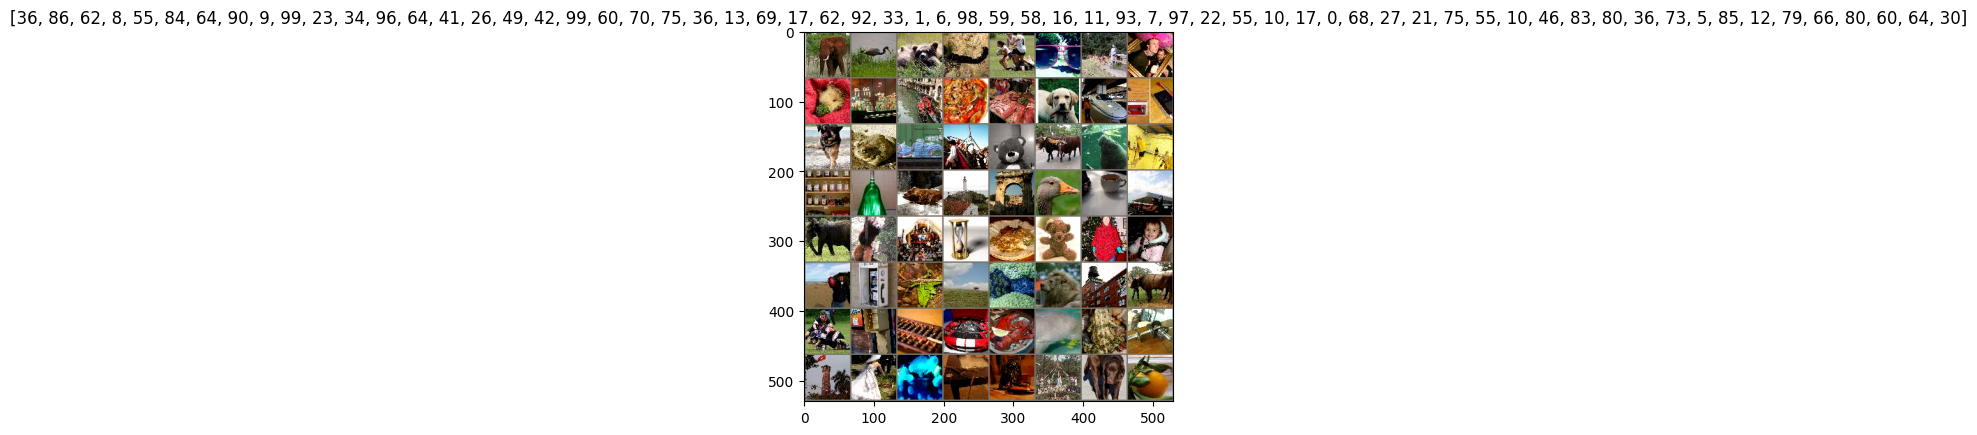

In [19]:
# Get a batch of training data
inputs, classes = next(iter(train_loader_task2))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

In [20]:
model_task2 = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_task2.fc = nn.Linear(num_ftrs, 100)

model_task2 = model_task2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_task2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_task2 = train_model(
    model_task2, criterion, optimizer_ft, exp_lr_scheduler, train_loader_task2,valid_loader_task2,num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 166.3826 Acc: 25.4256

Valid
	 Loss: 103.1278 Acc: 36.2102
Epoch 1/9
----------
Train
	 Loss: 92.1135 Acc: 37.8400

Valid
	 Loss: 91.7004 Acc: 37.7580
Epoch 2/9
----------
Train
	 Loss: 71.8360 Acc: 42.3344

Valid
	 Loss: 89.1167 Acc: 38.0955
Epoch 3/9
----------
Train
	 Loss: 57.7620 Acc: 45.9344

Valid
	 Loss: 89.0988 Acc: 37.9682
Epoch 4/9
----------
Train
	 Loss: 46.5798 Acc: 48.9728

Valid
	 Loss: 89.9065 Acc: 38.0892
Epoch 5/9
----------
Train
	 Loss: 37.3577 Acc: 51.8224

Valid
	 Loss: 92.6628 Acc: 37.7452
Epoch 6/9
----------
Train
	 Loss: 30.1634 Acc: 54.3184

Valid
	 Loss: 95.6747 Acc: 37.2229
Epoch 7/9
----------
Train
	 Loss: 22.9331 Acc: 57.1904

Valid
	 Loss: 94.8249 Acc: 37.6306
Epoch 8/9
----------
Train
	 Loss: 22.0988 Acc: 57.5648

Valid
	 Loss: 95.2804 Acc: 37.5287
Epoch 9/9
----------
Train
	 Loss: 21.1712 Acc: 57.8880

Valid
	 Loss: 95.1015 Acc: 37.8153
Training complete in 35m 17s
Best val Acc: 38.095543


In [22]:
create_submission(model_task2,transform,"task2",VAL_TASK2)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:27<00:00, 57.29it/s]


## Implement MPL 
Meta Pseudo Learning


In [17]:
import copy

In [27]:
teacher_model = copy.deepcopy(model_teacher)

CONFIDENCE = 0.80

# teacher_model.eval()

In [18]:
unlabeled_loader = DataLoader(dataset_unlabeled,batch_size=32,shuffle=True)


In [15]:
def generate_pseudo_labels(teacher_model, dataloader, confidences_threshold=0.8):
    # Store pseudo-labeled data
    pseudo_labeled_data = []

    teacher_model.eval()
    with torch.no_grad():
        for images, _, img_paths in tqdm(dataloader, desc="Generate PSEUDO-LABELS"):
            images = images.to(device)
            outputs = teacher_model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, pseudo_labels = torch.max(probabilities, dim=1)

            # Filter out low confidence predictions
            high_confidence_mask = confidences > confidences_threshold

            high_confidence_images = images[high_confidence_mask]
            high_confidence_labels = pseudo_labels[high_confidence_mask]
            high_confidence_paths = [
                img_paths[i] for i in range(len(img_paths)) if high_confidence_mask[i]
            ]

            for img, path, label in zip(
                high_confidence_images, high_confidence_paths, high_confidence_labels
            ):
                pseudo_labeled_data.append((img.cpu(), path, label.cpu()))

    pseudo_labels_dict = {
        "sample": [row[1] for row in pseudo_labeled_data],
        "label": [row[2].item() for row in pseudo_labeled_data],
    }

    df_pseudo = pd.DataFrame(pseudo_labels_dict)

    print(f"Generated new {len(df_pseudo)} pseudo labels")

    return df_pseudo

In [16]:
def create_combined_dataframe(data_path_1: str or Path, data_2: pd.DataFrame):
    df_labeled = pd.read_csv(data_path_1)

    print(type(df_labeled))

    df_labeled["sample"] = DATA_PATH + "/" + df_labeled["sample"]

    return pd.concat([df_labeled, data_2], ignore_index=True)

In [21]:
df_pseudo = generate_pseudo_labels(teacher_model, unlabeled_loader)

NameError: name 'teacher_model' is not defined

In [ ]:
combined_dataset = create_combined_dataframe(TRAIN_TASK1, df_pseudo)

<class 'pandas.core.frame.DataFrame'>


In [80]:
combined_set = CombinedDataset(
    combined_dataset["sample"].copy(), combined_dataset["label"].copy(), transform
)

0        /Users/marianluca/Documents/Master/ATAI/Homewo...
1        /Users/marianluca/Documents/Master/ATAI/Homewo...
2        /Users/marianluca/Documents/Master/ATAI/Homewo...
3        /Users/marianluca/Documents/Master/ATAI/Homewo...
4        /Users/marianluca/Documents/Master/ATAI/Homewo...
                               ...                        
40084    /Users/marianluca/Documents/Master/ATAI/Homewo...
40085    /Users/marianluca/Documents/Master/ATAI/Homewo...
40086    /Users/marianluca/Documents/Master/ATAI/Homewo...
40087    /Users/marianluca/Documents/Master/ATAI/Homewo...
40088    /Users/marianluca/Documents/Master/ATAI/Homewo...
Name: sample, Length: 40089, dtype: object
0         0
1         1
2         2
3         3
4         4
         ..
40084    50
40085    88
40086    55
40087    46
40088    85
Name: label, Length: 40089, dtype: int64


In [81]:
train_combined, test_combined = get_split_dataset(combined_set)

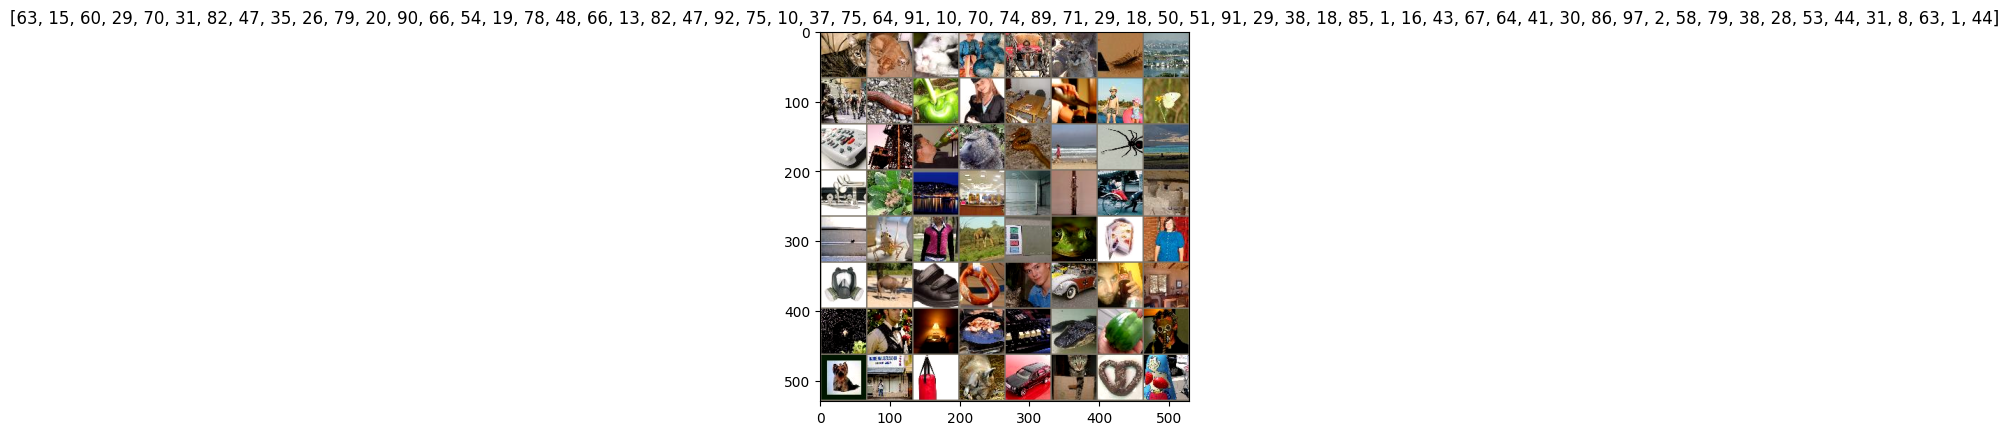

In [84]:
test_loader(train_combined)

In [85]:
student_model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = student_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
student_model.fc = nn.Linear(num_ftrs, 100)

student_model = student_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [86]:
stud = train_model(
    student_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_combined,
    test_combined,
    num_epochs=8,
)

Epoch 0/7
----------
Train
	 Loss: 136.1147 Acc: 35.4283

Valid
	 Loss: 57.2219 Acc: 49.4524
Epoch 1/7
----------
Train
	 Loss: 48.6227 Acc: 51.6036

Valid
	 Loss: 46.1460 Acc: 51.7063
Epoch 2/7
----------
Train
	 Loss: 31.6833 Acc: 55.6056

Valid
	 Loss: 44.1124 Acc: 52.3968
Epoch 3/7
----------
Train
	 Loss: 22.2286 Acc: 58.0239

Valid
	 Loss: 41.9007 Acc: 52.8254
Epoch 4/7
----------
Train
	 Loss: 15.4638 Acc: 60.0578

Valid
	 Loss: 42.2423 Acc: 53.0238
Epoch 5/7
----------
Train
	 Loss: 11.3930 Acc: 61.0319

Valid
	 Loss: 42.9054 Acc: 52.8810
Epoch 6/7
----------
Train
	 Loss: 8.3247 Acc: 61.9263

Valid
	 Loss: 43.6183 Acc: 53.0397
Epoch 7/7
----------
Train
	 Loss: 6.0641 Acc: 62.5498

Valid
	 Loss: 43.8548 Acc: 52.6746
Training complete in 31m 47s
Best val Acc: 53.039684


In [87]:
create_submission(student_model, transform, "task1", VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:52<00:00, 44.52it/s]


In [ ]:
def evaluate_model(model, criterion, valid_loader, title: str = "Model"):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    epoch_loss = running_loss / len(valid_loader)
    epoch_acc = running_corrects.float() / len(valid_loader)

    print(f"Valid {title}\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return epoch_acc


def train_simple(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    num_epochs=3,
    title="Training...",
):
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)

        for epoch in tqdm(num_epochs, desc=title):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Training phase
            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = running_corrects.float() / len(train_loader)

            print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model


def train_mlp(
    teacher_model,
    student_model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    unlabeled_loader,
    valid_loader,
    num_epochs=25,
):
    since = time.time()

    best_model = teacher_model
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # 1. Train Teacher Model on Labeled Data
        teacher_model = train_simple(
            teacher_model, criterion, optimizer, scheduler, train_loader
        )

        # 2. Generate Pseudo Labels for Unlabeled Data
        pseudo_labels = generate_pseudo_labels(teacher_model, unlabeled_loader, 0.9)

        # 3. Combine Pseudo Labels with Labeled Data
        combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

        augmented_data = CustomDataset(combined_data, transform_augmented)
        combined_loader = DataLoader(augmented_data, batch_size=64, shuffle=True)

        # 4. Train Student Model on Combined Data
        student_model = train_simple(
            student_model, criterion, optimizer, scheduler, combined_loader
        )

        # 5. Evaluate Student Model
        student_acc = evaluate_model(student_model, valid_loader)
        teacher_acc = evaluate_model(teacher_model, valid_loader)

        # 6. Update Teacher Model based on Student's Performance
        # 7. Save Best Student Model
        if student_acc > teacher_acc and student_acc > best_acc:
            best_acc = student_acc
            print("Update parameters teacher")
            teacher_model.load_state_dict(student_model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # Load best student model weights

    return teacher_model, student_model

### Implement Noisy Student

In [17]:
# student_noisy_model =
student_noisy_model = models.resnet50(weights="IMAGENET1K_V2")

num_ftrs = student_noisy_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
student_noisy_model.fc = nn.Linear(num_ftrs, 100)

# # Freeze all layers except the last two
# for param in student_noisy_model.parameters():
#     param.requires_grad = False
# for param in student_noisy_model.fc.parameters():
#     param.requires_grad = True

student_noisy_model = student_noisy_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(student_noisy_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [38]:
pseudo_labels = generate_pseudo_labels(model_teacher, unlabeled_loader,confidences_threshold=0.95)

combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

augmented_data = CustomDataset(combined_data, transform_augmented)

augmented_loader = DataLoader(augmented_data, batch_size=64, shuffle=True)

Generate PSEUDO-LABELS: 100%|██████████| 827/827 [00:46<00:00, 17.85it/s]

Generated new 11673 pseudo labels
<class 'pandas.core.frame.DataFrame'>


In [39]:
student_noisy_model = train_model(
    student_noisy_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    augmented_loader,
    valid_loader,
    num_epochs=10,
)

Epoch 0/9
----------
Train
	 Loss: 258.9727 Acc: 8.8276

Valid
	 Loss: 237.0605 Acc: 18.1892
Epoch 1/9
----------
Train
	 Loss: 188.7072 Acc: 20.8929

Valid
	 Loss: 274.7428 Acc: 14.5811
Epoch 2/9
----------
Train
	 Loss: 166.9696 Acc: 24.5172

Valid
	 Loss: 230.7163 Acc: 17.6892
Epoch 3/9
----------
Train
	 Loss: 155.8068 Acc: 26.7296

Valid
	 Loss: 200.5780 Acc: 22.6892
Epoch 4/9
----------
Train
	 Loss: 148.6182 Acc: 28.0018

Valid
	 Loss: 138.6353 Acc: 33.2297
Epoch 5/9
----------
Train
	 Loss: 143.4343 Acc: 29.0000

Valid
	 Loss: 139.6150 Acc: 33.3378
Epoch 6/9
----------
Train
	 Loss: 139.0712 Acc: 30.1071

Valid
	 Loss: 134.3980 Acc: 34.2432
Epoch 7/9
----------
Train
	 Loss: 134.5340 Acc: 30.9238

Valid
	 Loss: 140.1589 Acc: 33.3378
Epoch 8/9
----------
Train
	 Loss: 133.9809 Acc: 31.1470

Valid
	 Loss: 128.2362 Acc: 34.9189
Epoch 9/9
----------
Train
	 Loss: 132.5675 Acc: 31.1670

Valid
	 Loss: 131.1515 Acc: 35.0000
Training complete in 28m 26s
Best val Acc: 35.000000


In [32]:
teacher_model_iter = copy.deepcopy(model_teacher)

for _ in tqdm(range(3)):
    pseudo_labels = generate_pseudo_labels(teacher_model_iter, unlabeled_loader)

    combined_data = create_combined_dataframe(TRAIN_TASK1, pseudo_labels)

    augmented_data = CustomDataset(combined_data, transform_augmented)

    augmented_loader = DataLoader(augmented_data, batch_size=64, shuffle=True)

    student_noisy_model = train_model(
        student_noisy_model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        augmented_loader,
        valid_loader,
        num_epochs=15,
    )

    teacher_model_iter = student_noisy_model

  0%|          | 0/3 [00:00<?, ?it/s]

Generate PSEUDO-LABELS: 100%|██████████| 827/827 [00:49<00:00, 16.59it/s]


Generated new 16506 pseudo labels
<class 'pandas.core.frame.DataFrame'>
Epoch 0/7
----------
Train
	 Loss: 142.0982 Acc: 28.9872

Valid
	 Loss: 141.1630 Acc: 35.2432
Epoch 1/7
----------
Train
	 Loss: 139.4219 Acc: 29.6693

Valid
	 Loss: 139.9188 Acc: 35.7838
Epoch 2/7
----------
Train
	 Loss: 138.8674 Acc: 29.7444

Valid
	 Loss: 137.9332 Acc: 36.0405
Epoch 3/7
----------
Train
	 Loss: 138.4459 Acc: 29.7732

Valid
	 Loss: 128.8584 Acc: 37.3378
Epoch 4/7
----------
Train
	 Loss: 138.0232 Acc: 29.9936

Valid
	 Loss: 136.9796 Acc: 36.9189
Epoch 5/7
----------
Train
	 Loss: 136.5676 Acc: 30.2827

Valid
	 Loss: 132.8953 Acc: 36.7568
Epoch 6/7
----------
Train
	 Loss: 135.8854 Acc: 30.3546

Valid
	 Loss: 133.8227 Acc: 36.7973
Epoch 7/7
----------
Train
	 Loss: 135.8611 Acc: 30.4042



 33%|███▎      | 1/3 [27:30<55:01, 1650.78s/it]

Valid
	 Loss: 142.3385 Acc: 36.4189
Training complete in 26m 41s
Best val Acc: 37.337837


Generate PSEUDO-LABELS: 100%|██████████| 827/827 [01:13<00:00, 11.24it/s]


Generated new 3559 pseudo labels
<class 'pandas.core.frame.DataFrame'>
Epoch 0/7
----------
Train
	 Loss: 142.7523 Acc: 29.0189

Valid
	 Loss: 144.6109 Acc: 35.3649
Epoch 1/7
----------
Train
	 Loss: 143.0377 Acc: 28.9080

Valid
	 Loss: 139.3445 Acc: 36.0270
Epoch 2/7
----------
Train
	 Loss: 142.9339 Acc: 28.9953

Valid
	 Loss: 150.7571 Acc: 35.9595
Epoch 3/7
----------
Train
	 Loss: 143.1388 Acc: 28.9646

Valid
	 Loss: 138.6006 Acc: 36.6622
Epoch 4/7
----------
Train
	 Loss: 142.9249 Acc: 28.8868

Valid
	 Loss: 157.4440 Acc: 35.9865
Epoch 5/7
----------
Train
	 Loss: 142.9766 Acc: 28.9623

Valid
	 Loss: 138.4818 Acc: 36.4730
Epoch 6/7
----------
Train
	 Loss: 142.5004 Acc: 29.1132

Valid
	 Loss: 139.3033 Acc: 35.8649
Epoch 7/7
----------
Train
	 Loss: 143.7701 Acc: 28.8278



 67%|██████▋   | 2/3 [45:39<22:00, 1320.17s/it]

Valid
	 Loss: 137.3487 Acc: 36.2838
Training complete in 16m 55s
Best val Acc: 36.662163


Generate PSEUDO-LABELS: 100%|██████████| 827/827 [01:12<00:00, 11.42it/s]


Generated new 3113 pseudo labels
<class 'pandas.core.frame.DataFrame'>
Epoch 0/7
----------
Train
	 Loss: 144.3403 Acc: 28.5300

Valid
	 Loss: 139.3838 Acc: 36.2568
Epoch 1/7
----------
Train
	 Loss: 143.6006 Acc: 28.9904

Valid
	 Loss: 138.4956 Acc: 36.1486
Epoch 2/7
----------
Train
	 Loss: 144.3425 Acc: 28.7890

Valid
	 Loss: 140.4683 Acc: 36.6216
Epoch 3/7
----------
Train
	 Loss: 144.5158 Acc: 28.8513

Valid
	 Loss: 141.4993 Acc: 36.1892
Epoch 4/7
----------
Train
	 Loss: 143.6952 Acc: 28.8201

Valid
	 Loss: 139.2791 Acc: 35.8784
Epoch 5/7
----------
Train
	 Loss: 144.7435 Acc: 28.6763

Valid
	 Loss: 139.4887 Acc: 36.1486
Epoch 6/7
----------
Train
	 Loss: 143.8738 Acc: 28.9520

Valid
	 Loss: 138.4339 Acc: 36.2838
Epoch 7/7
----------
Train
	 Loss: 144.3279 Acc: 28.7842



100%|██████████| 3/3 [1:03:54<00:00, 1278.02s/it]

Valid
	 Loss: 137.7120 Acc: 36.1622
Training complete in 17m 2s
Best val Acc: 36.621620


In [29]:
create_submission(student_noisy_model, transform, "task1", VAL_TASK1)

Predict images: 100%|██████████| 5000/5000 [01:38<00:00, 50.89it/s]


In [24]:
def evaluate_model(model, criterion, valid_loader, title: str = "Model"):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    epoch_loss = running_loss / len(valid_loader)
    epoch_acc = running_corrects.float() / len(valid_loader)

    print(f"Valid {title}\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return epoch_acc


def train_noisy_student(
    teacher,
    student,
    criterion_teacher,
    optimizer_teacher,
    scheduler_teacher,
    criterion_student,
    optimizer_student,
    scheduler_student,
    train_loader,
    valid_loader,
    unlabeled_loader,
    num_epochs=25,
):
    teacher.to(device)
    student.to(device)

    # Train the model
    best_acc = 0.0
    best_model = None
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        running_loss_teacher = 0.0
        running_corrects_teacher = 0

        running_loss_student = 0.0
        running_corrects_student = 0

        student.train()
        teacher.train()

        for labeled_data, labels in train_loader:
            labeled_data = labeled_data.to(device)
            labels = labels.to(device)

            # Train on labeled data
            optimizer_teacher.zero_grad()
            outputs = teacher(labeled_data)
            _, preds = torch.max(outputs, 1)
            loss_teacher = criterion_teacher(outputs, labels)
            loss_teacher.backward()
            optimizer_teacher.step()

            teacher.eval()
            # Generate pseudo-labels for unlabeled data
            with torch.no_grad():
                unlabeled_data, _, _ = next(iter(unlabeled_loader))
                unlabeled_data = unlabeled_data.to(device)
                outputs = teacher(unlabeled_data)
                confidences, pseudo_labels = torch.max(outputs, 1)

                high_confidence_mask = confidences > 0.95
                unlabeled_data = unlabeled_data[high_confidence_mask]
                pseudo_labels = pseudo_labels[high_confidence_mask]

            # Train on labeled and pseudo-labeled data
            # Student model
            optimizer_student.zero_grad()
            labeled_outputs = student(labeled_data)
            unlabeled_outputs = student(unlabeled_data)
            loss_student = criterion_student(
                labeled_outputs, labels
            ) + criterion_student(unlabeled_outputs, pseudo_labels)
            loss_student.backward()
            optimizer_student.step()

            running_loss_teacher += loss_teacher.item() * labeled_data.size(0)
            running_corrects_teacher += torch.sum(preds == labels.data)

            # running_loss_student += loss.item() * labeled_data.size(0)
            # running_corrects_student += torch.sum(preds == labels.data)

        scheduler_teacher.step()
        scheduler_student.step()

        epoch_loss = running_loss_teacher / len(train_loader)
        epoch_acc = running_corrects_teacher.float() / len(train_loader)

        print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        teacher_acc = evaluate_model(
            teacher, criterion_teacher, valid_loader, "Teacher"
        )
        student_acc = evaluate_model(
            student, criterion_teacher, valid_loader, "Student"
        )

        if teacher_acc > best_acc:
            best_acc = teacher_acc
            best_model = teacher
            torch.save(teacher.state_dict(), "best_noisy_model.pt")
        elif student_acc > best_acc:
            best_acc = student_acc
            best_model = student
            torch.save(student.state_dict(), "best_noisy_model.pt")

    best_model.load_state_dict(torch.load("best_noisy_model.pt"))

    return best_model

In [25]:
model_teacher = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_teacher.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_teacher.fc = nn.Linear(num_ftrs, 100)

model_teacher = model_teacher.to(device)

criterion_teacher = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_teacher = optim.SGD(model_teacher.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_teacher = lr_scheduler.StepLR(optimizer_teacher, step_size=7, gamma=0.1)

In [27]:
# Define the fine-tuning model
student_noisy_model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_teacher.fc.in_features
# Replace the last fully connected layer with a linear layer with 10 output features for CIFAR-10
student_noisy_model.fc = nn.Linear(num_ftrs, 100)

# Define the loss function and optimizer
criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.SGD(student_noisy_model.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_student = lr_scheduler.StepLR(
    optimizer_student, step_size=7, gamma=0.1
)

# Define the data transforms
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load the labeled data
dataset = LabeledData(TRAIN_TASK1, transform=transform)
trainset, testset = get_split_dataset(dataset, batch_size=64)

# Load the unlabeled data
unlabeledset = UnlabeledData(TRAIN_TASK1_UNLABELED, transform=transform)
unlabeledloader = DataLoader(unlabeledset, batch_size=64, shuffle=True)

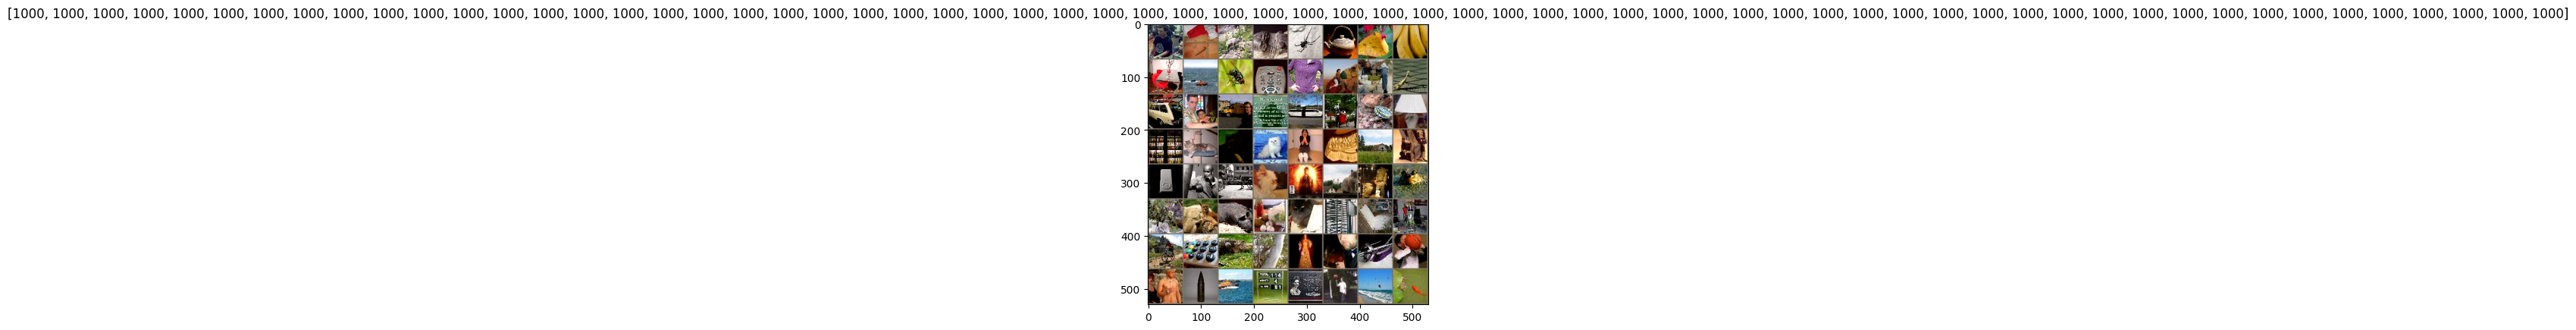

In [28]:
test_loader(unlabeledloader, is_labeled=False
            )

In [29]:
model = train_noisy_student(
    model_teacher,
    student_noisy_model,
    criterion_teacher,
    optimizer_teacher,
    exp_lr_scheduler_teacher,
    criterion_student,
    optimizer_student,
    exp_lr_scheduler_student,
    train_loader,
    valid_loader,
    unlabeledloader,
    13,
)

Epoch 0/12
----------
Train
	 Loss: 127.8930 Acc: 34.3322
Valid Teacher
	 Loss: 74.9268 Acc: 44.1216
Valid Student
	 Loss: 83.4360 Acc: 42.3378
Epoch 1/12
----------
Train
	 Loss: 62.0416 Acc: 47.4610
Valid Teacher
	 Loss: 72.7812 Acc: 44.5676
Valid Student
	 Loss: 69.2790 Acc: 45.4459
Epoch 2/12
----------
Train
	 Loss: 41.4089 Acc: 52.5356
Valid Teacher
	 Loss: 71.0207 Acc: 46.0811
Valid Student
	 Loss: 64.9830 Acc: 46.1081
Epoch 3/12
----------
Train
	 Loss: 26.6699 Acc: 56.3356
Valid Teacher
	 Loss: 73.4926 Acc: 45.9865
Valid Student
	 Loss: 64.1260 Acc: 46.5541
Epoch 4/12
----------
Train
	 Loss: 16.6223 Acc: 59.0000
Valid Teacher
	 Loss: 81.1516 Acc: 45.8243
Valid Student
	 Loss: 62.0583 Acc: 46.7703
Epoch 5/12
----------
Train
	 Loss: 11.8328 Acc: 60.4441
Valid Teacher
	 Loss: 83.7185 Acc: 46.2838
Valid Student
	 Loss: 62.6392 Acc: 46.9865
Epoch 6/12
----------
Train
	 Loss: 7.1724 Acc: 61.7763
Valid Teacher
	 Loss: 93.8260 Acc: 45.4054
Valid Student
	 Loss: 61.8906 Acc: 47.0811

In [31]:
create_submission(model, transform, "task1", VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:31<00:00, 54.67it/s]


## Train co-teaching

In [ ]:
def co_teaching_loss(model1_loss, model2_loss, rt):
    _, model1_sm_idx = torch.topk(
        model1_loss, k=int(int(model1_loss.size(0)) * rt), largest=False
    )
    _, model2_sm_idx = torch.topk(
        model2_loss, k=int(int(model2_loss.size(0)) * rt), largest=False
    )

    # co-teaching
    model1_loss_filter = torch.zeros((model1_loss.size(0))).to(device)
    model1_loss_filter[model2_sm_idx] = 1.0
    model1_loss = (model1_loss_filter * model1_loss).sum()

    model2_loss_filter = torch.zeros((model2_loss.size(0))).to(device)
    model2_loss_filter[model1_sm_idx] = 1.0
    model2_loss = (model2_loss_filter * model2_loss).sum()

    return model1_loss, model2_loss


def train_step(data_loader, model_list: list, optimizer, criterion, rt):
    global_step = 0
    avg_accuracy = 0.0
    avg_loss = 0.0

    model1, model2 = model_list
    model1 = model1.train()
    model2 = model2.train()
    for x, y, y_hat in data_loader:
        # Forward and Backward propagation
        x, y, y_hat = x.to(device), y.to(device), y_hat.to(device)

        out1 = model1(x)
        out2 = model2(x)

        model1_loss = criterion(out1, y_hat)
        model2_loss = criterion(out2, y_hat)
        model1_loss, model2_loss = co_teaching_loss(
            model1_loss=model1_loss, model2_loss=model2_loss, rt=rt
        )

        # loss exchange
        optimizer.zero_grad()
        model1_loss.backward()
        torch.nn.utils.clip_grad_norm_(model1.parameters(), 5.0)
        optimizer.step()

        optimizer.zero_grad()
        model2_loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 5.0)
        optimizer.step()

        avg_loss += model1_loss.item() + model2_loss.item()

        # Compute accuracy
        acc = torch.eq(torch.argmax(out1, 1), y).float()
        avg_accuracy += acc.mean()
        global_step += 1

    return avg_accuracy / global_step, avg_loss / global_step, [model1, model2]


def test_step(data_loader, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
    return avg_accuracy / global_step


def valid_step(data_loader, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.0

    for x, y, y_hat in data_loader:
        x, y, y_hat = x.to(device), y.to(device), y_hat.to(device)

        logits = model(x)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
    return avg_accuracy / global_step


def update_reduce_step(cur_step, num_gradual, tau=0.5):
    return 1.0 - tau * min(cur_step / num_gradual, 1)


# flags.DEFINE_float("tau", 0.5, "the estimated noise ratio")
# flags.DEFINE_integer(
#     "num_gradual", 5, "the number of gradual step (T_k = 5, 10, 15), default: 15"
# )
# flags.DEFINE_float("noise_prob", 0.5, "noise probability in training data")
# flags.DEFINE_string("noise_type", "sym", "noise type (sym, asym), default: sym")


def train(train_data_loader, valid_data_loader,tau=0.5,num_gradual=15,noise_prob=0.5 ,num_epochs=10):
    model1 = models.resnet50()
    model2 = models.resnet50()

    model1.to(device)
    model2.to(device)

    # learning history
    train_acc_list = []
    test_acc_list = []

    criterion = nn.CrossEntropyLoss(reduce=False)
    optimizer = optim.Adam(chain(model1.parameters(), model2.parameters()), lr=FLAGS.lr)

    for e in range(num_epochs):
        # update reduce step
        rt = update_reduce_step(
            cur_step=e, num_gradual=num_gradual, tau=tau
        )

        # training step
        train_accuracy, avg_loss, model_list = train_step(
            data_loader=train_data_loader,
            model_list=[model1, model2],
            optimizer=optimizer,
            criterion=criterion,
            rt=rt,
        )
        model1, model2 = model_list

        # testing/valid step
        test_accuracy = test_step(data_loader=test_data_loader, model=model1)

        dev_accuracy = valid_step(data_loader=valid_data_loader, model=model1)

        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)

        print(
            "{} epoch, Train Loss {}, Train accuracy {}, Dev accuracy {}, Test accuracy {}, Reduce rate {}".format(
                e + 1, avg_loss, train_accuracy, dev_accuracy, test_accuracy, rt
            )
        )